# ECAPA-TDNNでの話者照合


Hugging Faceで公開されているECAPA-TDNNを用いて、話者照合を行いましょう。


環境構築が簡単なので、Google Colab上で実行することをお勧めします。


もし手元のPCで動かしたい、Google Colabの使い方が分からないなど要望があれば、いつでも相談してください！


 * Hugging Faceの公式ページ -> https://huggingface.co/

* 今回用いるECAPA-TDNNのページ ->https://huggingface.co/speechbrain/spkrec-ecapa-voxceleb

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/CS_seminar/5th

/content/drive/MyDrive/CS_seminar/5th


In [3]:
#pythonのバージョン確認
!python -V

Python 3.10.12


In [4]:
#cudaのバージョン確認
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [5]:
#必要なライブラリのインストール
!pip install speechbrain
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install matplotlib japanize-matplotlib typing scipy scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.6/630.6 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.4/116.4 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 20.3 MB/s eta 0:00:00
Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 46.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=bd85be19245fe4ac842a0aae3eace2e9286e6fc552efd0e9184058109d26379b
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26308 sha256=

In [6]:
#事前学習モデルのロード
from speechbrain.pretrained import SpeakerRecognition
verification = SpeakerRecognition.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb", savedir="pretrained_models/spkrec-ecapa-voxceleb")

hyperparams.yaml:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

embedding_model.ckpt:   0%|          | 0.00/83.3M [00:00<?, ?B/s]

mean_var_norm_emb.ckpt:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

classifier.ckpt:   0%|          | 0.00/5.53M [00:00<?, ?B/s]

label_encoder.txt:   0%|          | 0.00/129k [00:00<?, ?B/s]

## EERのプロット

In [7]:
from typing import List
from scipy.interpolate import interp1d
from scipy.optimize import brentq
from sklearn.metrics import roc_curve ,auc

from tqdm import tqdm

In [8]:
#EERを求める関数
#FRR=1-TPRであることに留意
def compute_eer(labels: List[int], scores: List[float]):
    fpr, tpr, thresholds = roc_curve(labels, scores, pos_label=1)
    eer = brentq(lambda x: 1.0 - x - interp1d(fpr, tpr)(x), 0.0, 1.0)
    eer_threshold = interp1d(fpr, thresholds)(eer)
    return fpr, tpr, thresholds, eer, eer_threshold

In [10]:
#wavファイルのパスのペアと本人どうし(1)かそうじゃない(0)かをラベル付けしたファイルを用意する(サンプルも共有しておくので中身も確認してみてください)
#このファイルには"ラベル wav1 wav2"という風に書いてあるので、ファイルを1行ずつ読み込んで空白で区切って読み込んでいきます。
#ファイルの中身も自分たちが使う音声ファイルのパスに合わせてください。

filepath = "../data/list/__.txt" #ここは任意に変更

labels = []
wav1 = []
wav2 = []

with open(filepath) as f:
  for line in f:
    line = line.rstrip().split(' ')
    labels.append(int(line[0]))
    wav1.append(line[1])
    wav2.append(line[2])

print(f"pairs:{len(labels)}")
print(labels)
print(wav1)
print(wav2)

pairs:820
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,

In [11]:
scores = []
for i in tqdm(range(len(labels))):
  score, prediction = verification.verify_files(wav1[i], wav2[i])
  scores.append(score.item())
print(scores)

  0%|          | 0/820 [00:00<?, ?it/s]


OSError: ignored

In [ ]:
fpr, tpr, th, eer, eer_th = compute_eer(labels, scores)

In [ ]:
print("fpr: ", fpr)
print("tpr: ", tpr)
print("roc_th: ", th)
print("eer: ", eer)
print("eer_th: ", eer_th)

fpr:  [0.00000000e+00 1.49790294e-04 1.49790294e-04 ... 9.73337328e-01
 9.73337328e-01 1.00000000e+00]
tpr:  [0.         0.         0.01684211 ... 0.99894737 1.         1.        ]
roc_th:  [ 1.87394762  0.87394762  0.77739519 ... -0.10469993 -0.10522105
 -0.2173762 ]
eer:  0.23157894736797383
eer_th:  0.16281284480409383


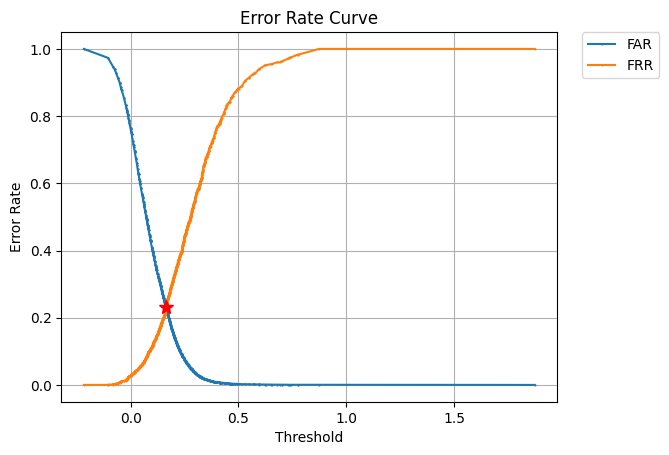

In [ ]:
#FAR,FRR,EERの図のプロット
import matplotlib.pyplot as plt
plt.plot(th, fpr, marker='o', markersize=1, label="FAR")
plt.plot(th, 1-tpr, marker='o', markersize=1, label="FRR")
plt.plot(eer_th,eer,marker='*', markersize=10, color="red")
plt.xlabel('Threshold')
plt.ylabel('Error Rate')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=10)
plt.title("Error Rate Curve")
plt.grid()

0.8526575951562548


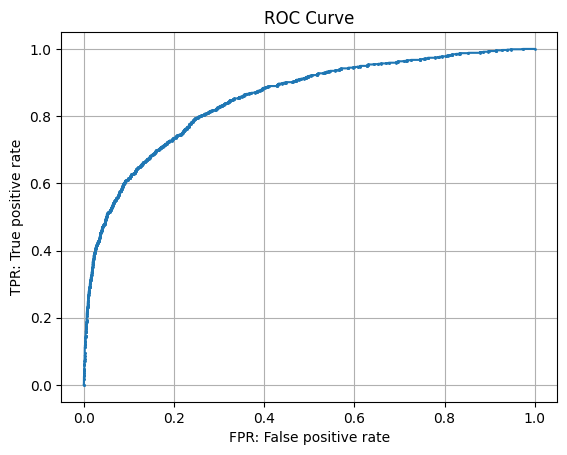

In [ ]:
#ROC曲線のプロット
plt.plot(fpr, tpr, marker='o', markersize=1)
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.title("ROC Curve")
plt.grid()
print(auc(fpr, tpr))

---

ちなみに，正しく照合できなかった発話対は…

In [ ]:
FNs = []
FPs = []
for idx in range(len(labels)):
  FN = labels[idx] == 1 and scores[idx] < eer_th # false negative, 偽陰性，同一だけど違う判定
  FP = labels[idx] == 0 and scores[idx] >= eer_th # false positive, 偽陽性, 異者だけど同一話者判定
  if FN:
    FNs.append((wav1[idx], wav2[idx]))
  if FP:
    FPs.append((wav1[idx], wav2[idx]))

print(f"--False Negatives:{len(FNs)}")
print(f"--False Positives:{len(FPs)}")

--False Negatives:220
--False Positives:1546


FalsePositiveが多いので，thresholdを少し大きくしてみる．

このモデルを実用するなら，このくらいがいいのかな？

In [ ]:
th_mod = eer_th + 0.2
print(f"th:{th_mod}")

FNs = []
FPs = []
for idx in range(len(labels)):
  FN = labels[idx] == 1 and scores[idx] < th_mod # false negative, 偽陰性，同一だけど違う判定
  FP = labels[idx] == 0 and scores[idx] >= th_mod # false positive, 偽陽性, 異者だけど同一話者判定
  if FN:
    FNs.append((wav1[idx], wav2[idx]))
  if FP:
    FPs.append((wav1[idx], wav2[idx]))

print(f"--False Negatives:{len(FNs)}")
print(f"--False Positives:{len(FPs)}")

th:0.3628128448040938
--False Negatives:664
--False Positives:90


In [ ]:
fns_filter = [(
    re.match(r".*/(.+?/.+?)\.wav", fn[0]).group(1),
    re.match(r".*/(.+?/.+?)\.wav", fn[1]).group(1)
)
for fn in FNs]
print(*fns_filter[::9],sep='\n')

('ntm/0_sp_m_c', 'ntm/5_sp_c')
('ntm/1_sp_m_c', 'ntm/3_sp_m_c_nz')
('ntm/2_sp_m_c', 'ntm/3_sp_m_c_nz')
('ntm/3_sp_m_c', 'ntm/1_sp_m_c_nz')
('ntm/4_sp_c', 'ntm/7_sp_c_nz')
('ntm/6_sp_c', 'ntm/0_sp_m_c_nz')
('ntm/7_sp_c', 'ntm/3_sp_m_c_nz')
('ntm/2_sp_m_c_nz', 'ntm/5_sp_c_nz')
('ayu/0_sp_b', 'ayu/2_sp_b_nz')
('ayu/0_sp_b_nz', 'ayu/2_sp_b_nz')
('tani/0_sp_b', 'tani/2_sp_b_nz')
('tani/1_sp_b', 'tani/4_sp_m_c_nz')
('tani/2_sp_b', 'tani/4_sp_m_c_nz')
('tani/3_sp_b', 'tani/6_sp_m_c_nz')
('tani/5_sp_m_c', 'tani/7_sp_m_c')
('tani/6_sp_m_c', 'tani/0_sp_b_nz')
('tani/7_sp_m_c', 'tani/3_sp_b_nz')
('tani/0_sp_b_nz', 'tani/6_sp_m_c_nz')
('tani/3_sp_b_nz', 'tani/6_sp_m_c_nz')
('ymgt/3_sp_a', 'ymgt/11_pc_c')
('ymgt/3_sp_a', 'ymgt/10_pc_c_nz')
('ymgt/2_sp_a', 'ymgt/10_pc_c')
('ymgt/2_sp_a', 'ymgt/7_sp_m_c_nz')
('ymgt/1_sp_a', 'ymgt/6_sp_m_c')
('ymgt/1_sp_a', 'ymgt/2_sp_a_nz')
('ymgt/1_sp_a', 'ymgt/13_pc_m_c_nz')
('ymgt/0_sp_a', 'ymgt/15_pc_m_c')
('ymgt/0_sp_a', 'ymgt/13_pc_m_c_nz')
('ymgt/4_sp_m_c', 'y

マスクとノイズの影響で，同一話者の拒否がある
マスクの影響をできるだけ排除するような学習をするか，録音機材等をなるべく統一すると違うかもしれない．

マスク

---

In [ ]:
import os
import re

class Speaker():
  def __init__(self, dir_path):
    self._dirname = re.match(r".*/([a-zA-Z]+?)\Z", dir_path).group(1)
    self._dir_path = dir_path
    self._speech_count = 0
    self._errors = {
        "mn": 0, # masked and noised
        "_n": 0, # no mask and noised
        "m_": 0, # masked and no noise
        "__": 0, # no mask and no noise
    }
    self.get_speech_count()

  def get_speech_count(self):
    itemlist = os.listdir(self._dir_path)
    count = 0
    for item in itemlist:
      if re.match(r".*\.wav", item) != None:
        count += 1
    self._speech_count = count

  def gen_error_dict(self, labels, wav1, wav2, scores, threshold):
    for idx in range(len(labels)):
      wav1_speaker = re.match(r".*/(.+?)/.+\.wav", wav1[idx]).group(1)
      wav2_speaker = re.match(r".*/(.+?)/.+\.wav", wav2[idx]).group(1)

      if wav1_speaker == self._dirname and wav2_speaker != self._dirname:
        fname1 = re.match(r".*/(.+)\.wav", wav1[idx]).group(1)
        mask_flag = re.search(r"[(_m)(mask)]", fname1)
        nz_flag = re.search(r"[(_nz)(noise)]", fname1)
      if wav1_speaker != self._dirname and wav2_speaker == self._dirname:
        fname2 = re.match(r".*/(.+)\.wav", wav2[idx]).group(1)
        mask_flag = re.search(r"[(_m)(mask)]", fname2)
        nz_flag = re.search(r"[(_nz)(noise)]", fname2)
      if wav1_speaker == self._dirname and wav2_speaker == self._dirname:
        fname1 = re.match(r".*/(.+?)/.+\.wav", wav1[idx]).group(1)
        fname2 = re.match(r".*/(.+)\.wav", wav2[idx]).group(1)
        mask_flag = (
            re.search(r"[(_m)(mask)]", fname1)
            or
            re.search(r"[(_m)(mask)]", fname2)
        )
        nz_flag = (
            re.search(r"[(_nz)(noise)]", fname1)
            or
            re.search(r"[(_nz)(noise)]", fname2)
        )
      else:

        continue

      if mask_flag and nz_flag:
        self._errors["mn"] += 1
      elif mask_flag:
        self._errors["m_"] += 1
      elif nz_flag:
        self._errors["_n"] += 1
      else:
        self._errors["__"] += 1



In [ ]:
%cd /content/drive/MyDrive/CS_seminar/_data/wav

/content/drive/MyDrive/CS_seminar/_data/wav


In [ ]:
!ls


abe  ayu  hre_A  hre_B	hre_C  ktg  mrym  ntm  shina  tani  tmng  wav_pair_list.txt  ymgt  yskw


In [ ]:
ymgt = Speaker("./ymgt")
ymgt.gen_error_dict(labels, wav1, wav2, scores, th_mod)

print(ymgt._errors)

{'mn': 496, '_n': 0, 'm_': 0, '__': 0}


In [ ]:
errors = FNs + FPs


('/content/drive/MyDrive/CS_seminar/_data/wav/ntm/2_sp_m_c.wav', '/content/drive/MyDrive/CS_seminar/_data/wav/tani/4_sp_m_c.wav')
('/content/drive/MyDrive/CS_seminar/_data/wav/ntm/5_sp_c_nz.wav', '/content/drive/MyDrive/CS_seminar/_data/wav/tani/3_sp_b_nz.wav')
('/content/drive/MyDrive/CS_seminar/_data/wav/tani/4_sp_m_c.wav', '/content/drive/MyDrive/CS_seminar/_data/wav/ymgt/7_sp_m_c.wav')
('/content/drive/MyDrive/CS_seminar/_data/wav/mrym/cszemi-noise(PC).wav', '/content/drive/MyDrive/CS_seminar/_data/wav/hre_B/Bs.wav')
('/content/drive/MyDrive/CS_seminar/_data/wav/mrym/cszemi1113(PC).wav', '/content/drive/MyDrive/CS_seminar/_data/wav/abe/iphone.wav')
('/content/drive/MyDrive/CS_seminar/_data/wav/hre_A/As.wav', '/content/drive/MyDrive/CS_seminar/_data/wav/hre_B/Bs_nz.wav')
('/content/drive/MyDrive/CS_seminar/_data/wav/hre_A/Ap_nz.wav', '/content/drive/MyDrive/CS_seminar/_data/wav/hre_C/Cs.wav')
('/content/drive/MyDrive/CS_seminar/_data/wav/hre_A/As_nz.wav', '/content/drive/MyDrive/CS_